In [1]:
%pylab inline
import sys 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sympy import *
from gplearn.fitness import make_fitness

Populating the interactive namespace from numpy and matplotlib


## Import features dataset and clean it

In [3]:
data_raw = pd.read_pickle('../Feature_extraction/Save_extractions/4b_7f.pkl')

# CHOOSE TWO CLASSES TO CLASSIFY
class1 = 90 
class2 = 42

# CHOOSE THE NUMBER OF OBJECTS FOR EACH CLASS
nb1 = 1000
nb2 = 1000


data_raw = data_raw[(data_raw['TARGET']==class1) | (data_raw['TARGET']==class2)]

mask1 = data_raw['TARGET'] == class1
mask2 = data_raw['TARGET'] == class2

data1 = data_raw[mask1]
data2 = data_raw[mask2]

data1_final = data1.sample(n=nb1, replace=False)
data2_final = data2.sample(n=nb2, replace=False)
data = pd.concat([data1_final,data2_final], ignore_index=True)

all_features = data.iloc[:,1:(shape(data)[1]-1)]
all_classes = np.array(data['TARGET'])
unique_classes = np.unique(list(all_classes))

# Print the shape of the final data
all_features.head()

,amplitude2,chi22,beyond_1_std2,mean_variance2,skew2,kurtosis2,stetson_K2,amplitude3,chi23,beyond_1_std3,...,skew4,kurtosis4,stetson_K4,amplitude5,chi25,beyond_1_std5,mean_variance5,skew5,kurtosis5,stetson_K5
0,3.222094,86.371427,0.375000,0.622553,0.668030,-0.734758,0.795410,1.821372,69.720824,0.375000,...,-0.322820,-2.096419,0.912052,0.324659,2.021999,0.250000,0.205524,-1.394787,1.740109,0.906646
1,3.096162,1607.473065,0.454545,0.548570,0.201385,-1.017022,0.871224,2.824164,765.316530,0.272727,...,-0.084487,0.442157,0.773022,1.804770,23.205723,0.272727,0.321610,-0.607484,0.863231,0.798832
2,2.349323,148.913848,0.400000,0.628482,0.311898,-2.599858,0.810756,1.334467,69.860003,0.333333,...,0.341685,-0.611808,0.839702,0.283020,2.130146,0.250000,0.211031,0.385774,-3.205932,0.927604
3,2.430122,156.149040,0.444444,0.538205,-0.100295,-1.852296,0.870977,1.979616,82.897977,0.500000,...,0.021356,-1.765931,0.930858,0.531164,4.236939,0.500000,0.282852,0.200337,-1.559973,0.884708
4,1.075247,22.695525,0.375000,0.363367,-0.103637,-0.992068,0.796245,0.861579,28.974642,0.500000,...,0.191189,-1.562541,0.927291,0.653978,2.816780,0.250000,0.250447,-0.640335,-0.440653,0.869511


### Choose a subset of features :

In [4]:
feature_tochoose = [*all_features.columns]
features = all_features.loc[:,feature_tochoose]

### Choose an attractor goal value for each type of object

In [5]:
goal1 = 5
goal2 = -5


# AUTO CREATE A DICTIONARY
dic_classes = {class1:goal1, class2:goal2}
dic_classes

{90: 5, 42: -5}

### Build training and testing sample

In [6]:
# Then split it into train and test samples
X_train, X_test, y_train, y_test = train_test_split(features, data['TARGET'], test_size=0.30, random_state=42)

## Evolve towards ideal function

In [7]:
#Import evolution scripts
sys.path.append(os.path.abspath('../Scripts'))
from create_model import *

### Define a custom cost function

In [8]:
def _mape(y, y_pred, w):
    
    diffs = (np.abs(y - y_pred))**2
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

### Choose the parameters 

In [9]:
features = X_train
classes = y_train

save = 'Model_saves/first_try'
population_size=500
generations=100
metric = mape

p_crossover=0.6
p_subtree_mutation=0.2
p_hoist_mutation=0.05
p_point_mutation=0.1

### Create your function

In [25]:
#GENERATE A MODEL
#model = evolve(features, classes, dic_classes, save, population_size=population_size, generations=generations,metric=mape)

#OR LOAD A PREVIOUS MODEL
model = pd.read_pickle('Model_saves/first_try.pkl')

NB : A save of this function is created in a .pkl file

## Analyse the performance of the model

In [26]:
# Import the plotting scripts
sys.path.append(os.path.abspath('../Scripts'))
from plot import *

### Choose parameters

In [27]:
# For the dictionary, we simply reverse the previous one
dic_goals = {v: k for k, v in dic_classes.items()}

function = model
classes = y_test
features = X_test

### Scatter plots :

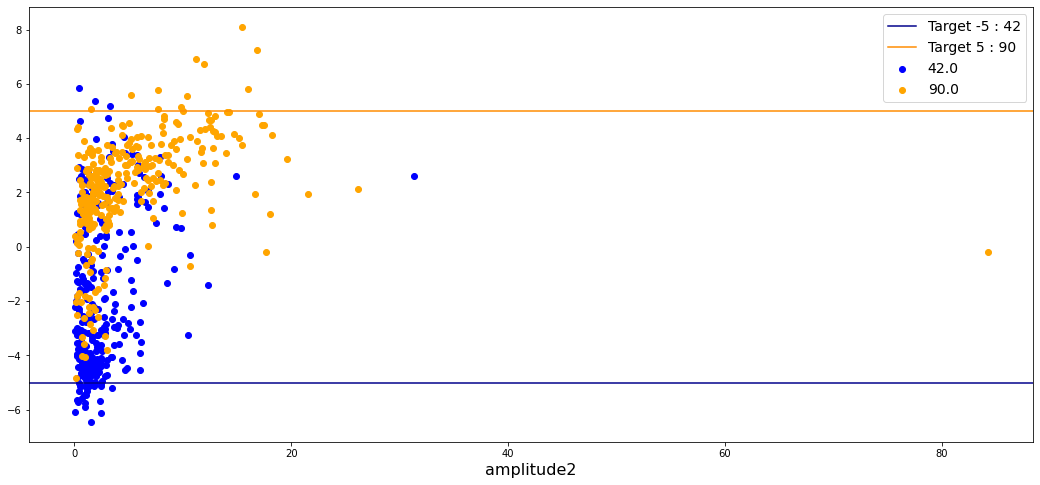

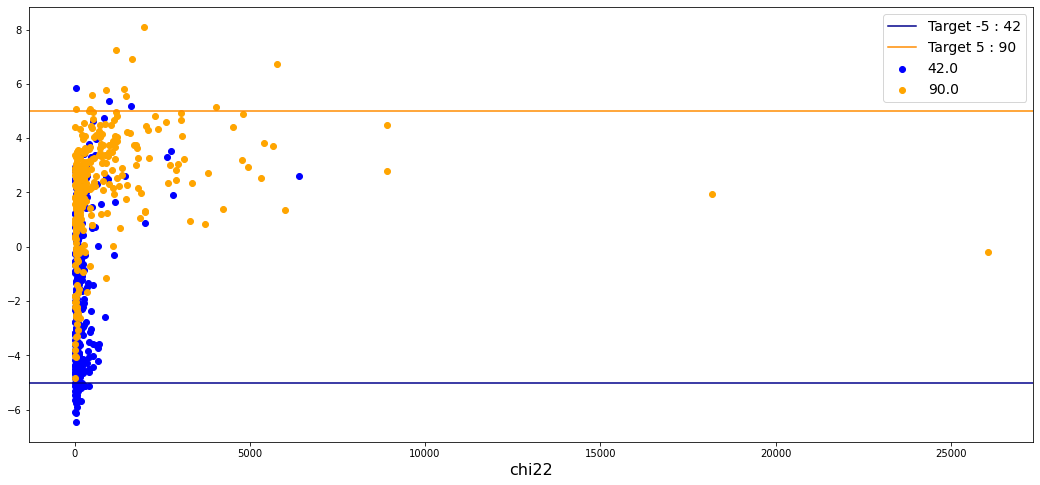

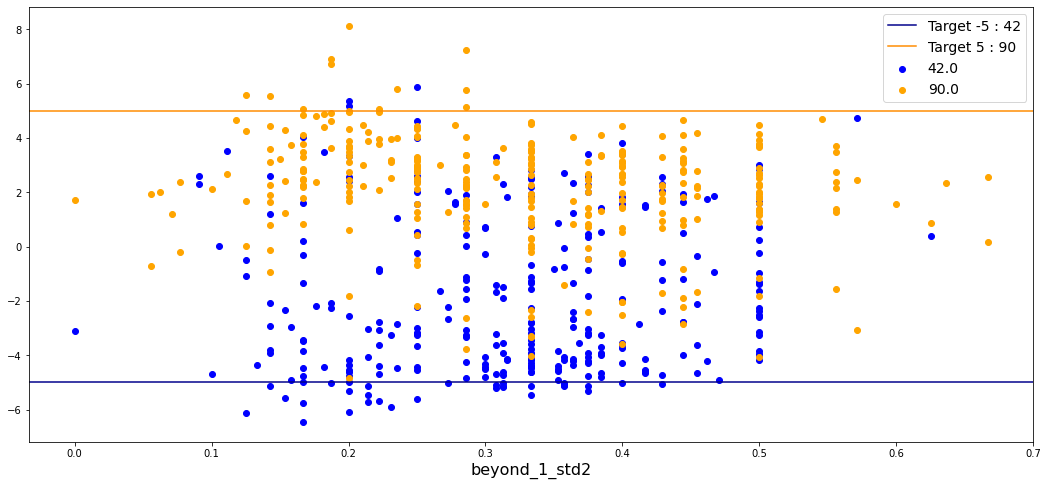

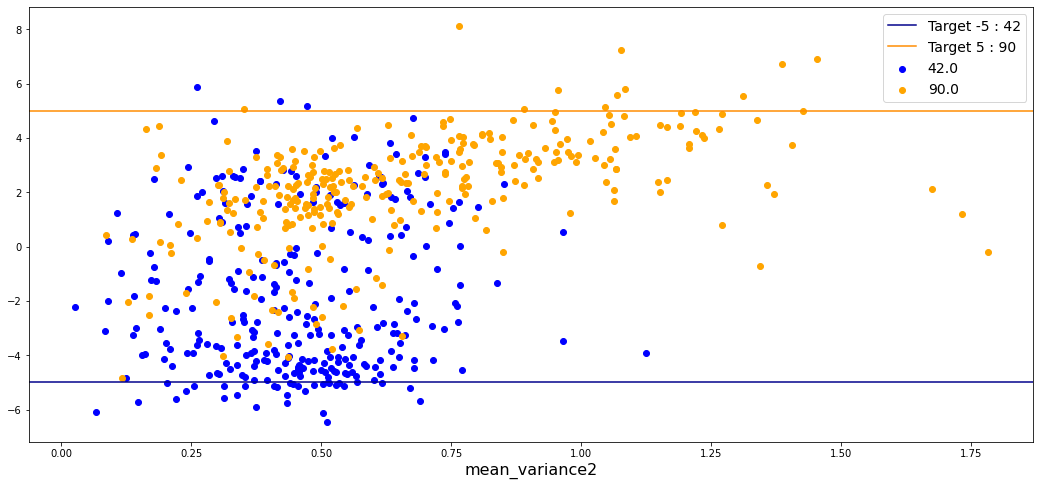

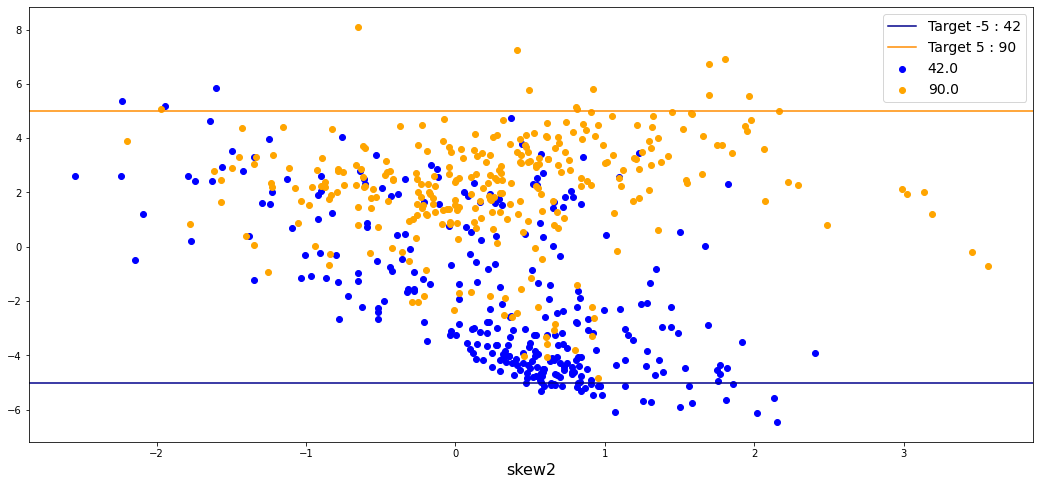

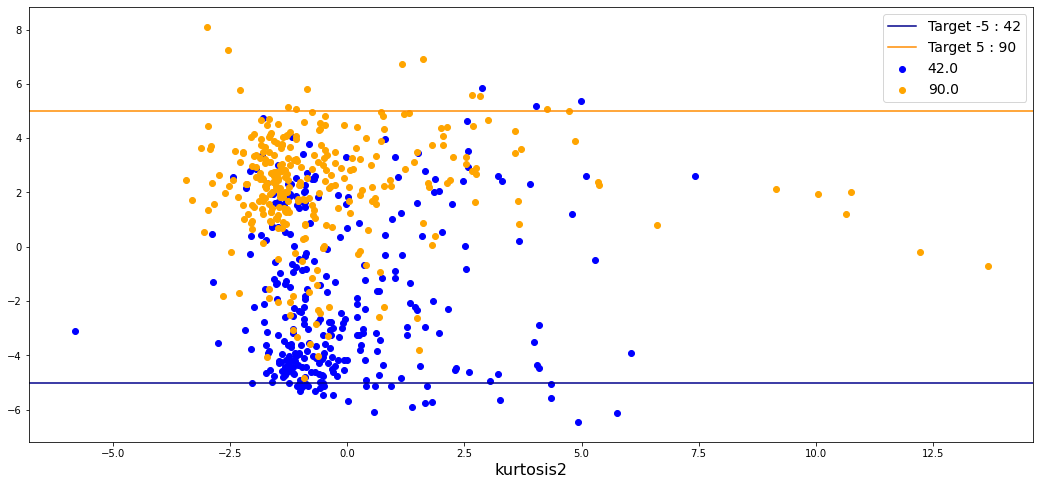

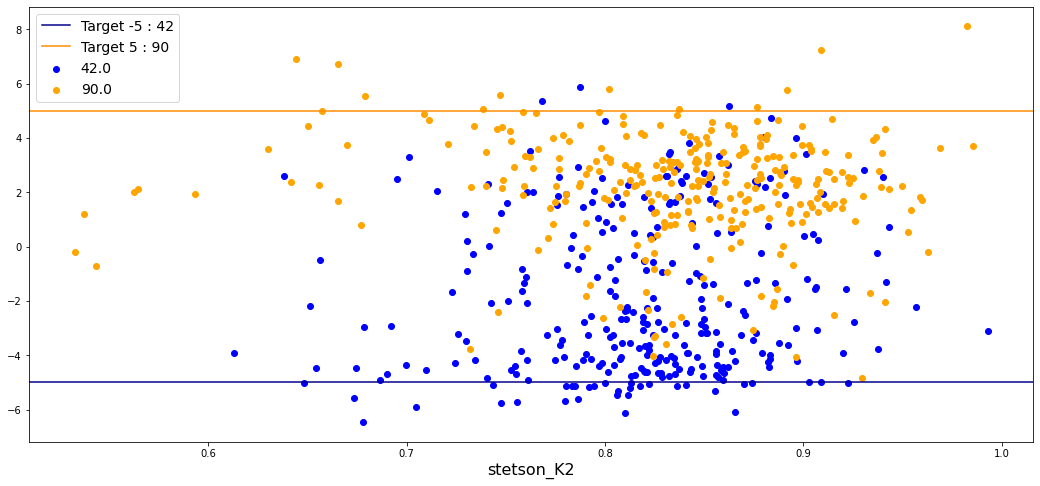

In [28]:
for i in feature_tochoose[0:7]:

    plt.figure(figsize=(18,8))
    plt.xlabel(i,size = 16)
    scatter_plot(function,features,i,dic_goals,classes=classes)
    plt.legend(fontsize = 14)

### Histogram plot :

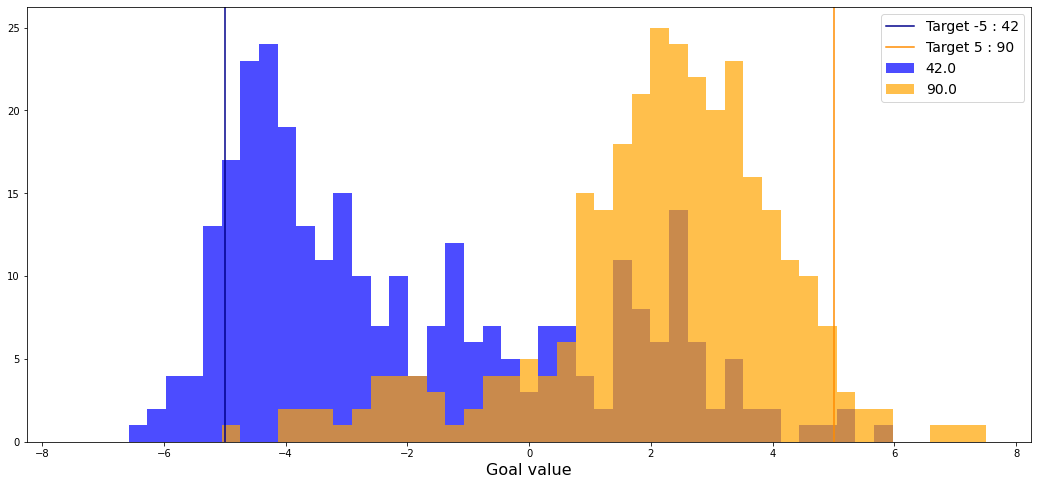

In [29]:
bins = np.linspace(-7.5,7.5,50)

plt.figure(figsize=(18,8))
plt.xlabel('Goal value',size = 16)
histo_plot(function,features,dic_goals,bins,classes = classes, alpha = 0.7)
plt.legend(fontsize = 14)

In [30]:
for thresh in [0]:
    resultat = model.predict(X_test)
    prediction = resultat.copy()
    prediction[resultat>thresh] = class1
    prediction[resultat<=thresh] = class2
    accuracy = (prediction == y_test).sum()*100/len(prediction)

    print('Le percent of good answers with a threshold to %s is : %s'%(thresh,accuracy))

Le percent of good answers with a threshold to 0 is : 79.66666666666667


In [31]:
# Print the mathematical equation of the function
sympify((str(model._program)), locals=converter)

-mean_variance2 + 6*mean_variance3 + 2*mean_variance4 - 2*skew2 + sin(mean_variance3 + sin(2*mean_variance3 + 2*mean_variance4 - 2*skew2 - sin(beyond_1_std3 - mean_variance3 + cos(mean_variance2)) + sin(mean_variance3 + sin(mean_variance4) + stetson_K5/kurtosis2)) - cos(mean_variance3 - sin(cos(kurtosis2) - cos(mean_variance3 + mean_variance4)))) + sin(mean_variance3 + mean_variance4 + sin(mean_variance3 + sin(sin(mean_variance3 - sin(-mean_variance3 + sin(-mean_variance3 + sin(kurtosis2 + 2*mean_variance3 - mean_variance4 + 2*skew2 + stetson_K2 + sin(beyond_1_std3 - mean_variance3 + cos(mean_variance2)) - cos(beyond_1_std5)) + cos(mean_variance3 - sin(cos(kurtosis2) - cos(mean_variance3 + mean_variance4)))) + cos(kurtosis2)))) - cos(mean_variance2*stetson_K4*sin(beyond_1_std3))) - cos(1/mean_variance2) - cos(2*mean_variance3 + mean_variance4 + sin(2*mean_variance3 + mean_variance4 - skew2 + sin(mean_variance3 + sin(mean_variance3 - cos(kurtosis2) + cos(1/mean_variance2) + cos(1/(mean_